<a href="https://colab.research.google.com/github/ElahehSadeghabadi/E2E-Communication-based-on-Deep-Learning/blob/main/2_Interference_Channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2025 ElahehSadeghabadi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Single-antenna transmissions in a two-user interference channel with an AWGN channel and no fading from the following paper:**

[1] T. O'Shea and J. Hoydis, "*An Introduction to Deep Learning for the Physical Layer,*" in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017.

# Setup

In [ ]:
import numpy as np
import tensorflow as tf
from math import ceil, log

# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Resetting the name counters
tf.keras.backend.clear_session()

import matplotlib.pyplot as plt
from IPython.display import Image, display

In [ ]:
# You may need the following codes to display a figure you will save in Google drive:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# System Model

**Two-user interference channel:**  
User 1 (Tx1) wants to communicate with its receiver (Rx1). Likewise, User 2 (Tx2) wants to communicate with its own receiver (Rx2). They experience the interference of each other as well as additive Gaussian noise.

Assume that both users have the same message set $\mathcal{M}$, where $\left|\mathcal{M}\right|=2^k$, and both transmitters encode their signal in the same number of channel uses $n$.

In this part, signals and noise are complex-vaued. That is, the notation $(n,k)$ means each of the $2^k$ messages is transmitted over $n$ complex-valued channel uses.
\begin{align}
&\mathbf{y}_1 = \mathbf{x}_1 + \mathbf{x}_2 + \mathbf{n}_1,\\
&\mathbf{y}_2 = \mathbf{x}_2 + \mathbf{x}_1 + \mathbf{n}_2,\\
&\mathbf{x}_1,\mathbf{x}_2\in\mathbb{C}^n,\mathbf{n}_1,\mathbf{n}_2\sim \mathcal{CN}\left(0,\beta\mathbf{I}_n\right)
\end{align}

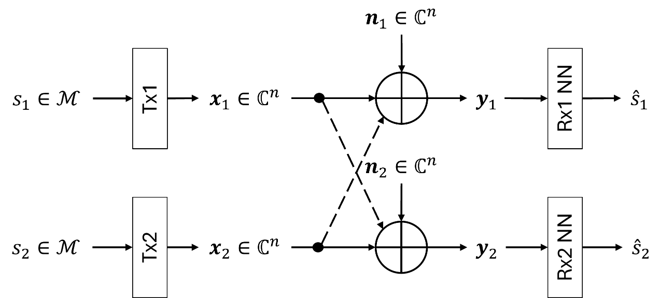

Figure 1: The two-user interference channel (based on [1, Figure 5]).

## Deep Learning-Based Model

**Transmitters and receivers neural networks:**  
The neural networks of transmitters and receivers for this system model are the same as that of the point-to-point communication system with an AWGN channel in `1_AWGN.ipynb`.

**Table 1: Tx1 and Tx2 Neural Networks**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Input (one-hot encoding)|$M$|-|
|Dense|$M$|`relu`|
|Dense|$2n$ (complex signaling)|`linear`|
|Normalization (transmitter constraint)|$2n$ (complex signaling)|-|

**Table 2: Rx1 and Rx2 Neural Networks**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Dense|$M$|`relu`|
|Dense|$M$|`softmax`|

**Loss function:**  
We are dealing with conflicting goals to recover both users' messages, so the so-called fairness problem in multi-user networks arises.

The whole neural network has two outputs and two inputs corresponding the two receivers and the two outputs. The authors in [1] define a loss function for each output and the overal loss function is the weighted sum of the two losses, i.e., $\tilde{L}=\alpha\tilde{L}_1+\left(1-\alpha\right)\tilde{L}_2$.

According to [1], $\alpha = 0.5$ does not result to equal performance for the two users. The authors of [1] propose an approach to dynamically choose the weight in each mini-batch as a function of the losses in the previous mini-batch:
\begin{align}
\alpha_{t+1} &= \frac{\tilde{L}_1\left(\mathbf{\theta}_t\right)}{\tilde{L}_1\left(\mathbf{\theta}_t\right)+\tilde{L}_2\left(\mathbf{\theta}_t\right)}, t>0
\end{align}
In this approach, if $\tilde{L}_1$ is smaller than $\tilde{L}_2$, the weight of user 1's loss reduces in the second mini-batch, so the training process focuses more on reducing user 2's loss.

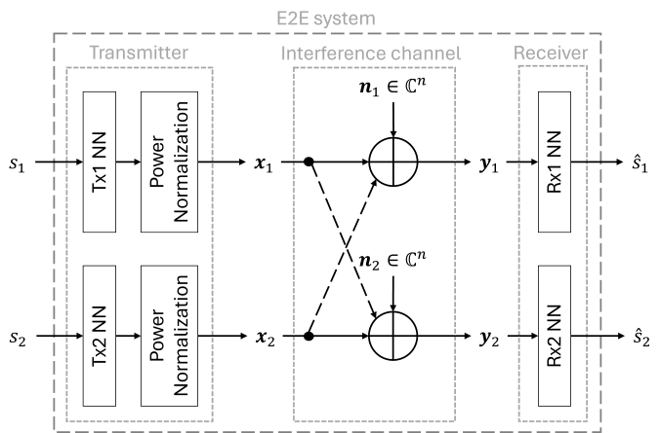

Figure 2: The end-to-end Deep Learning-based model is represented, where each of the transmitter, interference channel, and receiver have two inputs and two outputs.

# Creating and Training Models by TensorFlow and Keras

Before going forward to creating models by TensorFlow and Keras, don't forget to run the methods for transmitter constraints on codewords! These methods are in the following subsection, which are explained in detail in the file `Basics.ipynb`.

## Normalization (Transmitter Constraint)

Power constraint for complex signaling:

In [ ]:
def power_constraint_for_complex_signaling(x, n, power_limit = 1.0):
    """
    Applies an average power constraint of less than power_limit to each element of the complex codeword.

    x is a real tensor of dimension (batch_size, 2n), where 2n represents the real and imaginary parts of the codeword of length n.
    It is assumed that (i)th neuron and (i+n)th are respectively real and imaginary part of the (i)th element of the codeword.
    The power constraint is applied to to each element of the complex codeword.

    Args:
      x: Input tensor of shape (batch_size, 2n).
      n: Length of the codeword.
      power_limit: Power limit for each neuron.

    Returns:
      Tensor with constrained neuron outputs.
    """
    avg_power_per_neuron = tf.reduce_mean(tf.square(x), axis=0)
    avg_power_per_imaginary_neuron = avg_power_per_neuron[:n] + avg_power_per_neuron[n:2*n]
    avg_power_per_imaginary_neuron = tf.tile(avg_power_per_imaginary_neuron, [2])
    scale_factors = tf.where(avg_power_per_imaginary_neuron > 1.0,
                             tf.math.sqrt(1.0 / avg_power_per_imaginary_neuron),
                             tf.ones_like(avg_power_per_imaginary_neuron))
    return x * tf.expand_dims(scale_factors, axis=0)

## Creating and Training Tx and Rx Models

The method `E2E_two_user_IC` in the following creates and trains the neural networks for the two-user interference channel. The outputs of this method are the transmitters and receivers trained models.

Note that in this method, `tx_model` and `rx_model` have two inputs and two outputs corresponding the two users (see Figure 2).

To apply the loss function mentioned above, where the weight of each output loss changes dynamically, we need a custom training as the `compile` method and custom loss function techniques do not allow this.

In [ ]:
def E2E_two_user_IC(n,k, training_Eb_N0_dB = 7, n_samples = 50000, epochs = 10, batch_size = 1024, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), progress_print = True):
  # Here, we assume complex signaling  and power constraints on the codewords.

  tf.keras.backend.clear_session()# Resetting the name counters

  M = 2**k
  R = k/n
  # Messages====================================================================
  #Message indexing:
  messages = tf.random.uniform(shape=(2, n_samples,), minval=0, maxval=M, dtype=tf.int32)#Generating random integers using tensorflow
  #One-hot encoding of messages:
  messages_one_hot = tf.one_hot(messages, M)# one-hot encoding
  # user 1:
  X_train_1 = messages_one_hot[0,...]
  # user 2:
  X_train_2 = messages_one_hot[1,...]

  # Creating the model==========================================================
  # Transmitter-----------------------------------------------------------------
  # Transmitter model of user 1:
  inputs_1 = tf.keras.layers.Input(shape = [M])
  tx_signal_1 = tf.keras.layers.Dense(M, activation = "relu")(inputs_1)
  tx_signal_1 = tf.keras.layers.Dense(2*n)(tx_signal_1)# As the signal in this part is complex, n is replaced by 2*n
  tx_signal_1 = tf.keras.layers.Lambda(lambda x: power_constraint_for_complex_signaling(x, n, power_limit = 1.0), output_shape = (2*n,))(tx_signal_1)# power constraint on the codeword

  # Transmitter model of user 2:
  inputs_2 = tf.keras.layers.Input(shape = [M])
  tx_signal_2 = tf.keras.layers.Dense(M, activation = "relu")(inputs_2)
  tx_signal_2 = tf.keras.layers.Dense(2*n)(tx_signal_2)# As the signal in this part is complex, n is replaced by 2*n
  tx_signal_2 = tf.keras.layers.Lambda(lambda x: power_constraint_for_complex_signaling(x, n, power_limit = 1.0), output_shape = (2*n,))(tx_signal_2)# power constraint on the codeword

  tx_model = tf.keras.Model(inputs = [inputs_1, inputs_2], outputs = [tx_signal_1,tx_signal_2])
  # Channel---------------------------------------------------------------------
  # The E2E model is trained at Eb_N0 = training_Eb_N0_dB, but we use the trained model for all values of Eb_N0
  training_Eb_N0 = 10 ** (training_Eb_N0_dB/10) # 7dB
  noise_var = 1/(2*R*training_Eb_N0)
  noise_std = np.sqrt(noise_var)
  # ----------------------------------------------------------------------------
  # we can set the noise layer to be on during testing as in the following, but the E2E model is trained for Eb_N0 = 7dB and we wish to use it for any value of Eb_N0, so it does not work:
  ch_out_1 = tf.keras.layers.GaussianNoise(noise_std)(tx_signal_1 + tx_signal_2)
  ch_out_2 = tf.keras.layers.GaussianNoise(noise_std)(tx_signal_1 + tx_signal_2)
  # ----------------------------------------------------------------------------
  #ch_out = tf.keras.layers.GaussianNoise(noise_std)(tx_signal)
  ch_model = tf.keras.Model(inputs = [tx_signal_1, tx_signal_2], outputs = [ch_out_1, ch_out_2])
  # Receiver--------------------------------------------------------------------
  # Receiver model 1:
  rx_signal_1 = tf.keras.layers.Dense(M, activation = "relu")(ch_out_1)
  rx_signal_1 = tf.keras.layers.Dense(M, activation = "softmax")(rx_signal_1)

  # Receiver model 1:
  rx_signal_2 = tf.keras.layers.Dense(M, activation = "relu")(ch_out_2)
  rx_signal_2 = tf.keras.layers.Dense(M, activation = "softmax")(rx_signal_2)

  rx_model = tf.keras.Model(inputs = [ch_out_1, ch_out_2], outputs = [rx_signal_1, rx_signal_2])
  # E2E model-------------------------------------------------------------------
  input_1 = tf.keras.Input(shape=(M,))
  input_2 = tf.keras.Input(shape=(M,))
  tx_out_1, tx_out_2 = tx_model([input_1, input_2])
  ch_out_1, ch_out_2 = ch_model([tx_out_1, tx_out_2])
  rx_out_1, rx_out_2 = rx_model([ch_out_1, ch_out_2])
  e2e_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[rx_out_1, rx_out_2])

  # Training====================================================================
  n_steps = len(X_train_1) // batch_size
  weight = tf.constant(0.5)
  for epoch in range(1, epochs + 1):# epochs is the number of times we process the whole training set
    print(f"Epoch {epoch}/{epochs}")
    for step in range(1, n_steps + 1): #n_steps is the number of batches, so it's (# of samples in the training set)/(batch_size)
        X_batch_1 = X_train_1[batch_size * (step - 1): batch_size * step]
        X_batch_2 = X_train_2[batch_size * (step - 1): batch_size * step]
        with tf.GradientTape() as tape:
            y_pred_1, y_pred_2 = e2e_model((X_batch_1,X_batch_2), training=True) #Note the training = True: We ask the tape to compute the gradients of the loss with regard to each trainable variable- not all variables!
            loss1 = tf.keras.losses.CategoricalCrossentropy()(X_batch_1, y_pred_1)
            loss2 = tf.keras.losses.CategoricalCrossentropy()(X_batch_2, y_pred_2)
            loss = weight * loss1 + (1-weight) * loss2

        gradients = tape.gradient(loss, e2e_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, e2e_model.trainable_variables))

        #updating weight:
        weight = loss1/ (loss1 + loss2 + 1e-8)

        # Printing status
        if progress_print:
          end = "" if step < n_steps else "\n"
          print(f"\r{step}/{n_steps} - " + f"loss1: {loss1:.4f} - " + f"loss2: {loss2:.4f} - " + f"weight: {weight:.2f} - " + f"loss: {loss:.4f}", end=end)
  return tx_model, rx_model

# Evaluating

## BLER

In [ ]:
# Training hyperparameters:
constraint = 'power'
training_Eb_N0_dB = 7
n_samples = 100000
epochs = 20
batch_size= 1024
optimizer = tf.keras.optimizers.Adam
learning_rate=0.001

# Eb_N0 values in dB in BLER vs Eb_N0 plots:
Eb_N0_dB = np.linspace(0,14,15)
n_samples_BLER = 100000

# The BLER vs Eb_N0 for two simulation scenario will be represented:
# 1. (n,k) = (4,4)
# 2. (n,k) = (4,8)


plt.figure(figsize=(6,5))
for j,n,k in [(1,4,4),(2,4,8)]:
  M = 2**k
  R = k/n
  tx_model, rx_model = E2E_two_user_IC(n,k, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size = batch_size, optimizer = optimizer(learning_rate=learning_rate), progress_print = True)
  # BLER calculation--------------------------------------------------------------
  # Messages
  messages = tf.random.uniform(shape=(2, n_samples_BLER,), minval=0, maxval=M, dtype=tf.int32)#Generating random integers using tensorflow
  messages_1 = messages[0,...]
  messages_2 = messages[1,...]
  # One-hot encoding of messages:
  messages_one_hot = tf.one_hot(messages, M)# one-hot encoding
  # user 1:
  X_1 = messages_one_hot[0,...]
  # user 2:
  X_2 = messages_one_hot[1,...]
  # Iterating the values of Eb_N0-------------------------------------------------
  BLER1 = np.zeros(15,)
  BLER2 = np.zeros(15,)
  for i in range(15):
    # Tx:
    tx_signal_1, tx_signal_2 = tx_model((X_1,X_2))

    # Noise layer:
    Eb_N0 = 10 ** (Eb_N0_dB[i]/10)
    noise_var = 1/(2*R*Eb_N0)
    noise_std = np.sqrt(noise_var)
    noise1 = tf.random.normal(shape = tx_signal_1.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32,)
    noise2 = tf.random.normal(shape = tx_signal_2.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32,)
    noisy_signal_1 = tx_signal_1 + tx_signal_2 + noise1
    noisy_signal_2 = tx_signal_1 + tx_signal_2 + noise2

    # Rx:
    rx_signal_1, rx_signal_2 = rx_model((noisy_signal_1,noisy_signal_2))
    rx_signal_1 = rx_signal_1.numpy().argmax(axis = -1)
    rx_signal_2 = rx_signal_2.numpy().argmax(axis = -1)

    # Counting the number of false prediction:------------------------------------
    BLER1[i] = np.count_nonzero(rx_signal_1 != messages_1) / n_samples_BLER
    BLER2[i] = np.count_nonzero(rx_signal_2 != messages_2) / n_samples_BLER

  # Plot--------------------------------------------------------------------------
  if j == 1:
    BLER_plot1, = plt.plot(Eb_N0_dB, BLER1, 'r-o', label = 'User 1, '+r'$(n,k)=$' + f'({n},{k})')
    BLER_plot1.set_alpha(0.5)
    BLER_plot2, = plt.plot(Eb_N0_dB, BLER2, 'b-s', label = 'User 2, '+r'$(n,k)=$' + f'({n},{k})')
    BLER_plot2.set_alpha(0.5)
  else:
    BLER_plot1, = plt.plot(Eb_N0_dB, BLER1, 'r--o', label = 'User 1, '+r'$(n,k)=$' + f'({n},{k})')
    BLER_plot1.set_alpha(0.5)
    BLER_plot2, = plt.plot(Eb_N0_dB, BLER2, 'b--s', label = 'User 2, '+r'$(n,k)=$' + f'({n},{k})')
    BLER_plot2.set_alpha(0.5)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' +'(dB)')
plt.ylabel("Block Error Rate (BLER)")
plt.xlim([0,14])
plt.yscale("log")
plt.title('Two-user interference channel BLER vs '+r'$E_b/N_0$')
plt.grid()

plt.savefig(f"IC_BLER_EbN0.png")
# plt.show()
plt.close()

Epoch 1/20
97/97 - loss1: 2.4636 - loss2: 2.1367 - weight: 0.54 - loss: 2.3103
Epoch 2/20
97/97 - loss1: 1.3118 - loss2: 1.0182 - weight: 0.56 - loss: 1.1836
Epoch 3/20
97/97 - loss1: 0.7172 - loss2: 0.5695 - weight: 0.56 - loss: 0.6525
Epoch 4/20
97/97 - loss1: 0.4181 - loss2: 0.3554 - weight: 0.54 - loss: 0.3910
Epoch 5/20
97/97 - loss1: 0.2205 - loss2: 0.1966 - weight: 0.53 - loss: 0.2094
Epoch 6/20
97/97 - loss1: 0.1567 - loss2: 0.1229 - weight: 0.56 - loss: 0.1415
Epoch 7/20
97/97 - loss1: 0.1161 - loss2: 0.0880 - weight: 0.57 - loss: 0.1029
Epoch 8/20
97/97 - loss1: 0.0840 - loss2: 0.0670 - weight: 0.56 - loss: 0.0760
Epoch 9/20
97/97 - loss1: 0.0653 - loss2: 0.0593 - weight: 0.52 - loss: 0.0624
Epoch 10/20
97/97 - loss1: 0.0583 - loss2: 0.0488 - weight: 0.54 - loss: 0.0543
Epoch 11/20
97/97 - loss1: 0.0510 - loss2: 0.0468 - weight: 0.52 - loss: 0.0492
Epoch 12/20
97/97 - loss1: 0.0443 - loss2: 0.0337 - weight: 0.57 - loss: 0.0396
Epoch 13/20
97/97 - loss1: 0.0378 - loss2: 0.0338

Displaying saved plots:


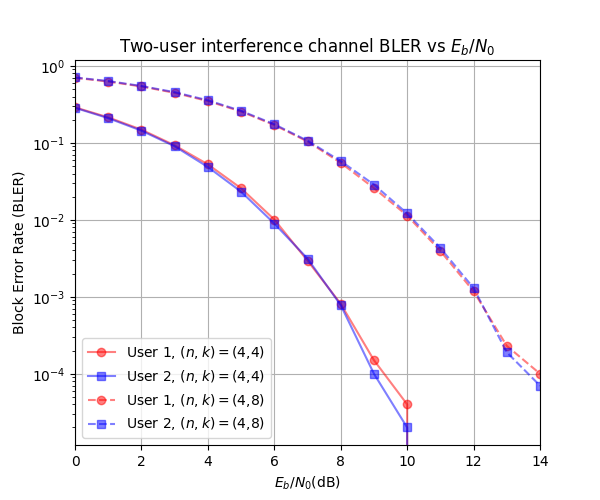

In [ ]:
from IPython.display import Image, display
print("Displaying saved plots:")
display(Image(filename="IC_BLER_EbN0.png"))

Similar to the results of `1_AWGN.ipynb`, the obtained results are not as good as the results of [1, Figure 6]. The cause of this difference may be the values of the training hyperparameters and/or the methods applying transmitter constraints.

## Visualizing Codewords Constellations

In [ ]:
# Training hyperparameters:
constraint = 'power'
training_Eb_N0_dB = 7
n_samples = 100000
epochs = 30
batch_size= 1024
optimizer = tf.keras.optimizers.Adam
learning_rate = 0.001

# Four codeword constellations will be represented:
# 1. (n,k) = (1,1) with energy constraint on codewords
# 2. (n,k) = (2,2) with energy constraint on codewords
# 3. (n,k) = (4,4) with power constraint on codewords
# 4. (n,k) = (4,8) with power constraint on codewords

for j, n, k in [(1,1,1),(2,2,2),(3,4,4),(4,4,8)]:
  M = 2**k
  tx_model, rx_model = E2E_two_user_IC(n,k, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size = batch_size, optimizer = optimizer(learning_rate=learning_rate), progress_print = True)
  symbols_1, symbols_2= tx_model.predict((tf.one_hot(tf.range(M),M),tf.one_hot(tf.range(M),M)))#(mess1,mess2))
  plt.figure(j,figsize=(16, 3.8))
  for i in range(n):
    plt.subplot(1,4,i+1)
    # (i)th neuron and (i+n)th are respectively real and imaginary part of the (i)th element of the codeword:
    plt.scatter(symbols_1[:, i], symbols_1[:, i+n], marker = '.', c = 'r')
    plt.scatter(symbols_2[:, i], symbols_2[:, i+n], marker = 'x', c = 'b')
    if i == 0:
      plt.xlabel('Real')
      plt.ylabel('Imaginary')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.title(r'$(n,k)=$'+f"({n}, {k})")
    plt.grid()
  plt.savefig(f"IC_codewords_{j}.png")
  plt.close()

Epoch 1/30
97/97 - loss1: 0.6628 - loss2: 0.6901 - weight: 0.49 - loss: 0.6768
Epoch 2/30
97/97 - loss1: 0.5077 - loss2: 0.6372 - weight: 0.44 - loss: 0.5808
Epoch 3/30
97/97 - loss1: 0.3170 - loss2: 0.4251 - weight: 0.43 - loss: 0.3798
Epoch 4/30
97/97 - loss1: 0.2135 - loss2: 0.2647 - weight: 0.45 - loss: 0.2426
Epoch 5/30
97/97 - loss1: 0.1684 - loss2: 0.1792 - weight: 0.48 - loss: 0.1742
Epoch 6/30
97/97 - loss1: 0.1406 - loss2: 0.1359 - weight: 0.51 - loss: 0.1382
Epoch 7/30
97/97 - loss1: 0.1165 - loss2: 0.1046 - weight: 0.53 - loss: 0.1108
Epoch 8/30
97/97 - loss1: 0.0977 - loss2: 0.0721 - weight: 0.58 - loss: 0.0862
Epoch 9/30
97/97 - loss1: 0.0817 - loss2: 0.0502 - weight: 0.62 - loss: 0.0693
Epoch 10/30
97/97 - loss1: 0.0716 - loss2: 0.0364 - weight: 0.66 - loss: 0.0591
Epoch 11/30
97/97 - loss1: 0.0633 - loss2: 0.0288 - weight: 0.69 - loss: 0.0521
Epoch 12/30
97/97 - loss1: 0.0550 - loss2: 0.0235 - weight: 0.70 - loss: 0.0445
Epoch 13/30
97/97 - loss1: 0.0464 - loss2: 0.0224

Displaying saved plots:


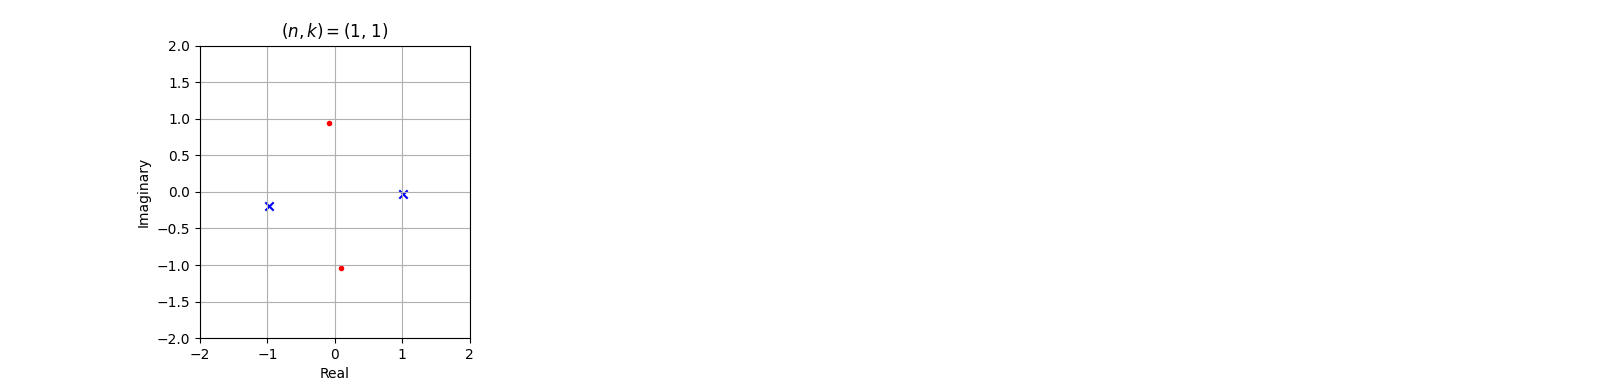

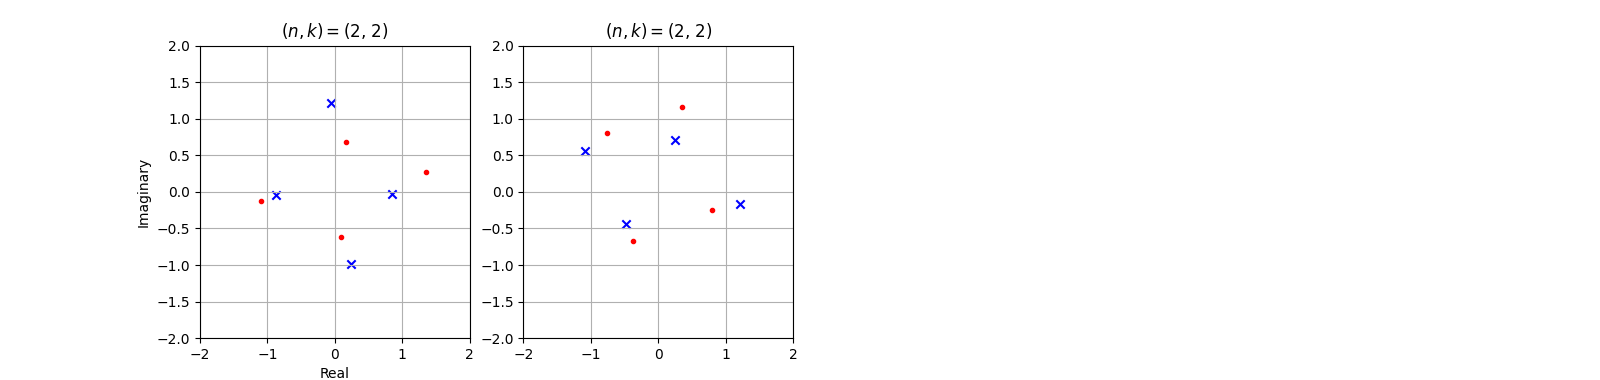

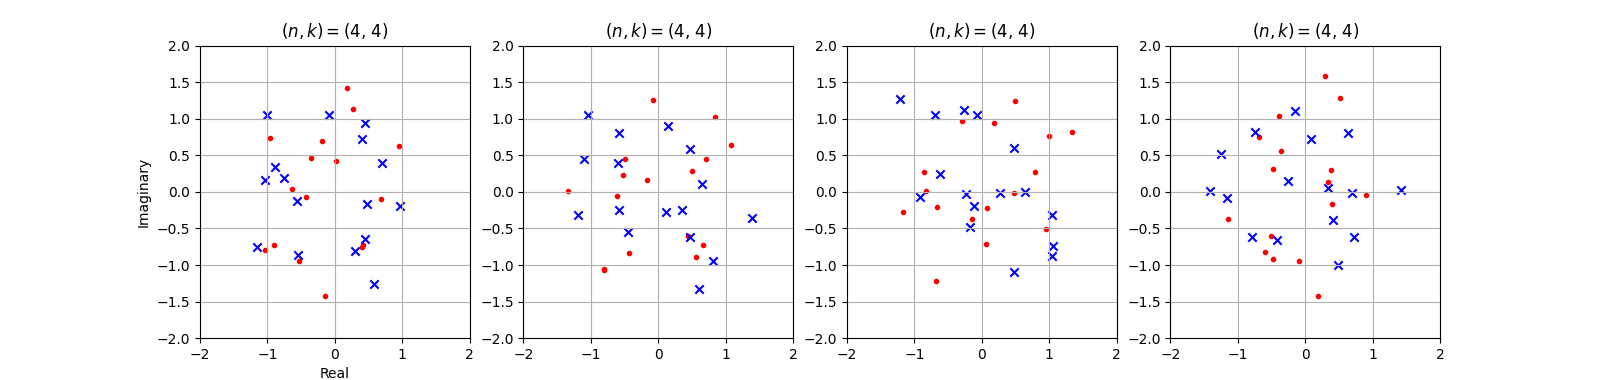

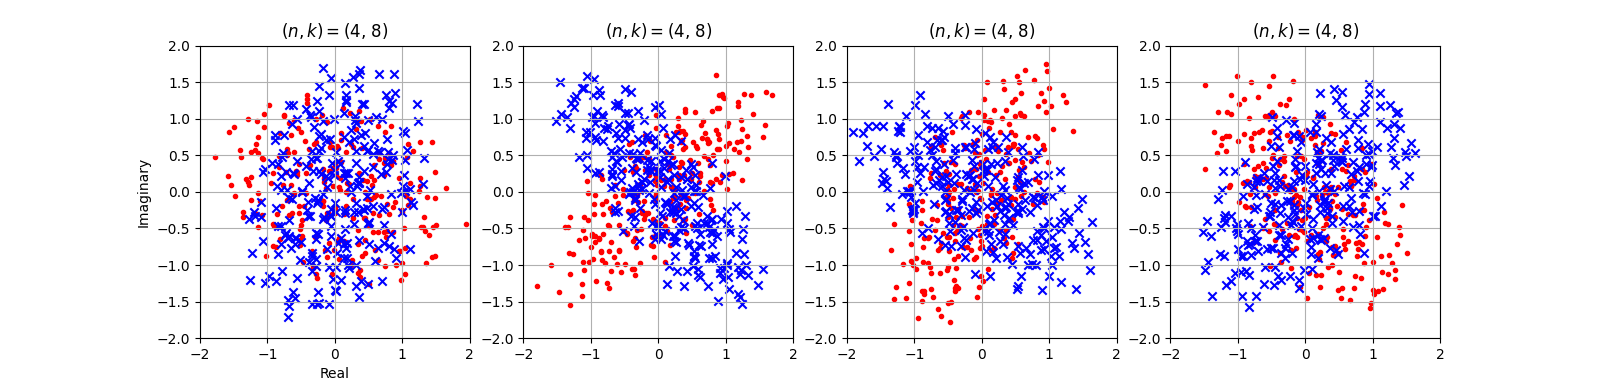

In [ ]:
print("Displaying saved plots:")
for j in range(1,5):
  display(Image(filename=f"IC_codewords_{j}.png"))

Overall, I can say that the simulated results are very similar to [1, Figure 7]. Plotting a $2n$ dimensional codeword in $n$ 2D plots may not represent the results clearly. Probably, the cause of the difference between our results and that of [1, Figure 7] is how we group the elements of the codeword in $n$ groups of 2, so I suppose even the simulated results for $(n,k)=(2,2)$ is similar to that of the paper.